# Exploration of Recipe1M+ using clustering
For the subset of recipes used in this example, see the [Recipe1M+](http://pic2recipe.csail.mit.edu/) dataset.
> Marin, J., Biswas, A., Ofli, F., Hynes, N., Salvador, A., Aytar, Y., ... & Torralba, A. (2019). Recipe1m+: A dataset for learning cross-modal embeddings for cooking recipes and food images. IEEE transactions on pattern analysis and machine intelligence, 43(1), 187-203.

See the extracted dataset sample [here](https://unimi2013.sharepoint.com/:u:/s/InformationRetrieval/EaL7kid2qzdCmAA8RO-m5iQBsvCl5cuNIdn0rsJN1FUhSg?e=fdXkkB)

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import os
import nltk

In [3]:
folder = "/Users/flint/Data/recipe/text-sample/"
files = [f for f in os.listdir(folder) if f.endswith('.txt')]
recipes = []
for file in files:
    with open(os.path.join(folder, file), 'r') as data:
        recipes.append(data.read())

## Extract ingredients to create a pseudo doc with the ingredients only

In [4]:
import re
from string import punctuation

In [5]:
def ingredient_tokenizer(recipe, pattern=r'-(.*?)\n'):
    pattern = re.compile(pattern)
    ingredients = []
    for ingredient_line in pattern.findall(recipe):
        parts = ingredient_line.split(', ')
        main_ingredient = parts[0].split('of ')[-1]
        tokens = ["".join([x for x in main_ingredient if x not in punctuation])]
        for token in parts[1:]:
            tokens.append("".join(x for x in token if x not in punctuation))
        ingredients += tokens
    return ingredients

In [6]:
corpus = [ingredient_tokenizer(r) for r in recipes]

## Vectorize
Try vectorizing the documents by TfIdf and by LDA

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [8]:
tfidf_vec = TfidfVectorizer(tokenizer=lambda x: x.split())
tfidf = tfidf_vec.fit_transform([" ".join(x) for x in corpus]).toarray()

In [9]:
lda_vec = LatentDirichletAllocation(n_components=20)
lda = lda_vec.fit_transform(tfidf)

### Explore topics

In [10]:
n_top_words = 6
description = []
feature_names = tfidf_vec.get_feature_names_out()
for topic_idx, topic in enumerate(lda_vec.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    for j, f in enumerate(top_features_ind):
        description.append({
            'topic': "T{}".format(topic_idx),
            'word': top_features[j],
            'score': round(weights[j], 3)
        })
T = pd.DataFrame(description)

In [17]:
T[T.topic=='T0'].sort_values('score', ascending=False)

,topic,word,score
0,T0,dressing,118.323
1,T0,mayonnaise,89.862
2,T0,regular,73.376
3,T0,salad,68.252
4,T0,raw,61.798
5,T0,prepared,47.239


### Visualize documents

In [18]:
from sklearn.decomposition import PCA

In [19]:
import matplotlib.pyplot as plt

In [20]:
pca_tfidf = PCA(n_components=2)
Xtfidf = pca_tfidf.fit_transform(tfidf)
pca_lda = PCA(n_components=2)
Xlda = pca_lda.fit_transform(lda)

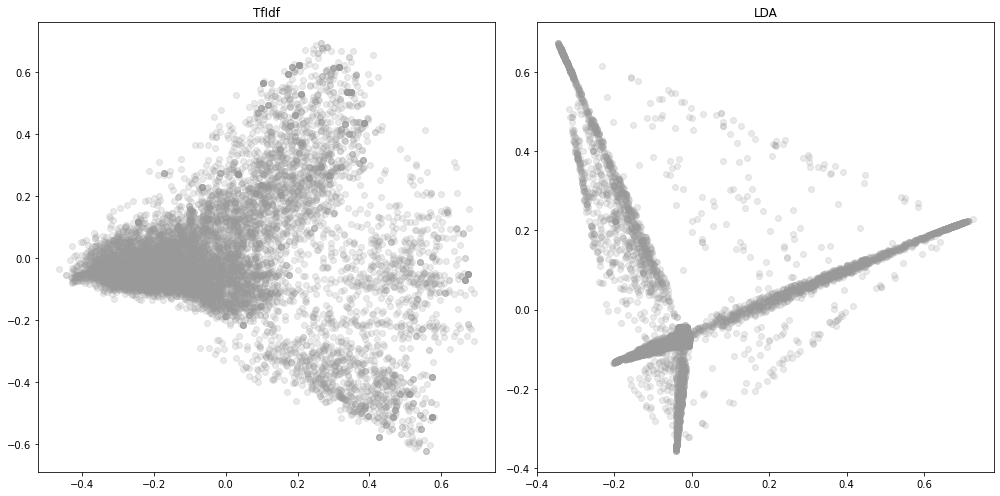

In [21]:
fig, ax = plt.subplots(figsize=(14, 7), ncols=2)
ax[0].scatter(Xtfidf[:,0], Xtfidf[:,1], alpha=0.2, c='#999999')
ax[1].scatter(Xlda[:,0], Xlda[:,1], alpha=0.2, c='#999999')
ax[0].set_title('TfIdf')
ax[1].set_title('LDA')
plt.tight_layout()
plt.show()

## Clustering

In [22]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [23]:
models = {
    'Kmeans': (KMeans, {'n_clusters': 10}),
    'Agglomerative': (AgglomerativeClustering, {'n_clusters': 10})
}

In [24]:
run = list(models.items())

In [25]:
tfidf_clustering = {}
for k, (model, params) in tqdm(run):
    m = model(**params)
    tfidf_clustering[k] = m.fit_predict(tfidf)

  0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
lda_clustering = {}
for k, (model, params) in tqdm(run):
    m = model(**params)
    lda_clustering[k] = m.fit_predict(lda)

  0%|          | 0/2 [00:00<?, ?it/s]

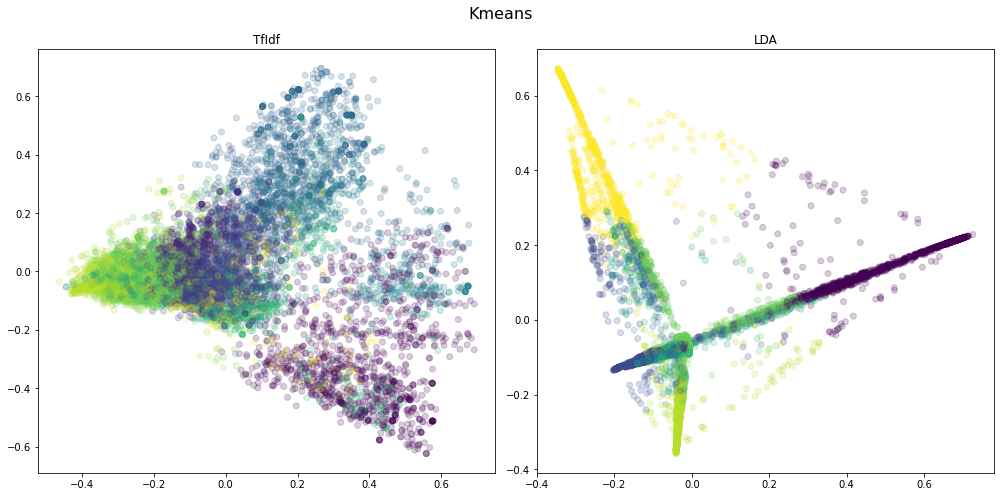

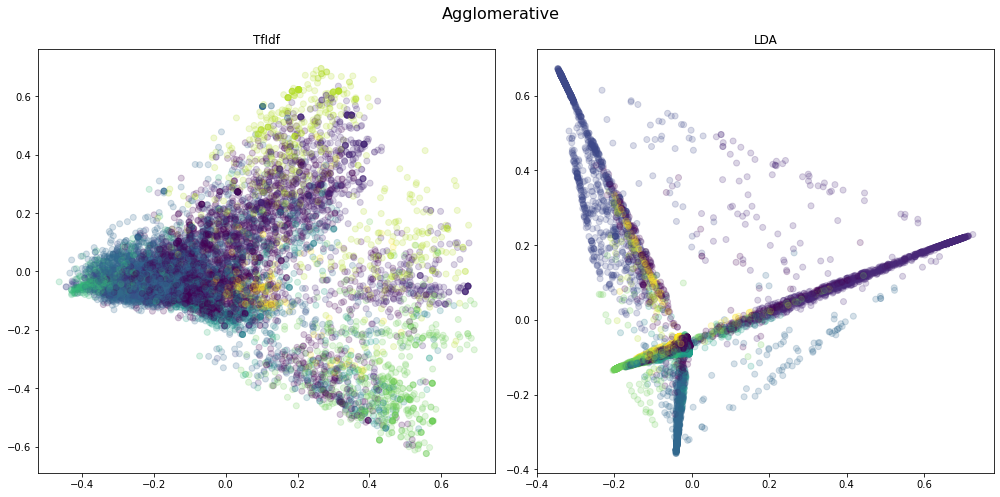

In [27]:
for model in models.keys():
    fig, ax = plt.subplots(figsize=(14, 7), ncols=2)
    fig.suptitle(model, fontsize=16)
    ax[0].scatter(Xtfidf[:,0], Xtfidf[:,1], alpha=0.2, c=tfidf_clustering[model])
    ax[1].scatter(Xlda[:,0], Xlda[:,1], alpha=0.2, c=lda_clustering[model])
    ax[0].set_title('TfIdf')
    ax[1].set_title('LDA')
    plt.tight_layout()
    plt.show()

## Cluster interpretation
**Exercize:** describe clusters by selecting the **top 10 specific and representative** features of each cluster.

In [28]:
from collections import defaultdict

In [53]:
assignment = tfidf_clustering['Kmeans']
assignment

array([7, 7, 8, ..., 4, 5, 1], dtype=int32)

In [54]:
vocabulary = tfidf_vec.get_feature_names_out()

In [55]:
def doc_vocabulary(doc_id, top_w=10):
    words_scores = sorted(enumerate(tfidf[doc_id]), key=lambda x: -x[1])
    return [(vocabulary[wid], score) for wid, score in words_scores[:top_w]]

In [56]:
cluster_desc = defaultdict(lambda: defaultdict(lambda: 0))
for doc_id, cluster_label in enumerate(assignment):
    for word, score in doc_vocabulary(doc_id):
        cluster_desc[cluster_label][word] += score

In [57]:
CL = pd.Series(cluster_desc[1])
CL.sort_values(ascending=False).iloc[:20]

raw             156.515847
juice           150.856603
bottled         138.377717
generic         135.959946
water           124.135160
granulated       92.015544
lemon            79.990366
sugars           79.008037
orange           72.315373
strawberries     53.653078
proof            44.386336
beverage         44.060017
distilled        42.719409
alcoholic        41.836516
lime             39.211218
blueberries      35.087134
cornstarch       34.760331
80               30.316466
vodka            28.426282
raspberries      28.383907
dtype: float64

**Exercize:** exploit the cluster to speed-up document search using the cluster pruning technique [https://nlp.stanford.edu/IR-book/html/htmledition/cluster-pruning-1.html](https://nlp.stanford.edu/IR-book/html/htmledition/cluster-pruning-1.html)